In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import random
import gc
%matplotlib inline


from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier, RandomForestRegressor, RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import *

In [49]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 600)
data = pd.read_csv('./input/DogMoveData.csv')


In [50]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [51]:
data.head(20)

,DogID,TestNum,t_sec,ABack_x,ABack_y,ABack_z,ANeck_x,ANeck_y,ANeck_z,GBack_x,GBack_y,GBack_z,GNeck_x,GNeck_y,GNeck_z,Task,Behavior_1,Behavior_2,Behavior_3,PointEvent
0,16,1,0.00,0.041504,0.938965,-0.015137,-0.067871,-0.510254,-0.934570,-17.639161,-22.766115,7.446290,-7.934571,6.347657,13.427735,<undefined>,<undefined>,<undefined>,<undefined>,<undefined>
1,16,1,0.01,0.041992,0.941895,-0.020020,-0.128906,-0.494141,-0.913086,-15.075685,-11.413575,4.821778,-3.906250,4.394532,16.540528,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
2,16,1,0.02,0.040527,0.939453,-0.004395,-0.158691,-0.480469,-0.911133,-12.207032,-0.122070,2.807617,-0.488281,-1.953125,26.794435,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
3,16,1,0.03,0.021484,0.946289,0.007813,-0.122070,-0.486816,-0.880371,-9.460450,7.995606,1.586914,1.159668,-5.676270,38.085940,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
4,16,1,0.04,-0.000977,0.951172,0.033691,-0.053711,-0.500000,-0.807129,-8.361817,14.587403,-1.037598,4.577637,4.089356,41.503909,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
5,16,1,0.05,-0.006348,0.955078,0.038574,0.019043,-0.463867,-0.749023,-9.826661,19.653322,-5.493164,12.939454,20.812990,32.531740,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
6,16,1,0.06,0.001953,0.959473,0.035156,0.045898,-0.376953,-0.781250,-11.657716,15.869142,-7.751465,22.705080,29.968264,14.038087,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
7,16,1,0.07,0.013672,0.958984,0.030273,0.028809,-0.307617,-0.941406,-13.671876,5.859375,-8.361817,23.925783,19.470216,-5.920411,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
8,16,1,0.08,0.028320,0.941895,0.045410,-0.014648,-0.349121,-1.100098,-16.113282,-1.220703,-8.483887,12.084962,-8.300782,-20.202638,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
9,16,1,0.09,0.028809,0.934082,0.065430,-0.061035,-0.480469,-1.129395,-18.859864,-0.183105,-7.812500,-3.845215,-37.475588,-24.475099,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>


In [52]:
data.tail(20)

,DogID,TestNum,t_sec,ABack_x,ABack_y,ABack_z,ANeck_x,ANeck_y,ANeck_z,GBack_x,GBack_y,GBack_z,GNeck_x,GNeck_y,GNeck_z,Task,Behavior_1,Behavior_2,Behavior_3,PointEvent
10611048,74,2,1928.04,0.242188,0.347168,0.880859,-0.380859,0.719238,-0.802246,-7.629395,41.931155,38.452151,13.427735,43.273928,-63.781742,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611049,74,2,1928.05,0.291504,0.255859,0.779785,-0.353027,0.701660,-0.944336,-22.155763,42.968753,36.499026,11.413575,43.273928,-72.082524,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611050,74,2,1928.06,0.373535,0.084961,0.802734,-0.337402,0.675293,-0.978516,-45.104983,42.907717,32.165529,3.784180,46.813968,-86.181646,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611051,74,2,1928.07,0.381348,-0.078125,0.898438,-0.319824,0.777344,-0.921875,-60.302738,40.100100,28.137209,-3.417969,57.250980,-99.853522,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611052,74,2,1928.08,0.251953,-0.068848,0.916992,-0.281250,1.013672,-0.856934,-48.522952,51.574710,29.052736,-13.671876,67.199711,-110.412604,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611053,74,2,1928.09,0.101074,0.064453,0.865723,-0.232910,1.150879,-0.871582,-16.662599,79.711919,33.569338,-35.095217,75.683598,-116.210945,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611054,74,2,1928.10,0.012207,0.297852,0.864258,-0.218262,1.090332,-0.901367,21.240236,88.195806,46.447757,-68.603520,79.223638,-122.619636,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611055,74,2,1928.11,0.148926,0.546875,0.822754,-0.213867,0.993164,-0.946289,46.997073,68.786625,66.223149,-101.196295,82.275396,-127.929695,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611056,74,2,1928.12,0.364258,0.684082,0.858398,-0.229492,0.859375,-0.894043,58.410648,43.518069,83.740239,-126.342781,90.942388,-132.446297,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611057,74,2,1928.13,0.536621,0.726074,0.765625,-0.264648,0.744141,-0.791992,58.959965,42.175296,86.730962,-136.047372,106.506354,-134.582528,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>


In [53]:
data= reduce_mem_usage(data)
data = data[~data['DogID'].isin([60, 61, 63, 65, 66, 67, 68, 70, 72, 73, 74])]
data.shape

Mem. usage decreased to 688.13 Mb (57.5% reduction)


(8421780, 20)

In [54]:
# del data['Behavior_1']
# del data['Behavior_2']
# del data['PointEvent']
data['Behavior_3']
# data['Behavior_3'] = data['Behavior_3'].replace('<undefined>', None)



0          <undefined>
1          <undefined>
2          <undefined>
3          <undefined>
4          <undefined>
              ...     
8421775    <undefined>
8421776    <undefined>
8421777    <undefined>
8421778    <undefined>
8421779    <undefined>
Name: Behavior_3, Length: 8421780, dtype: object

<AxesSubplot:>

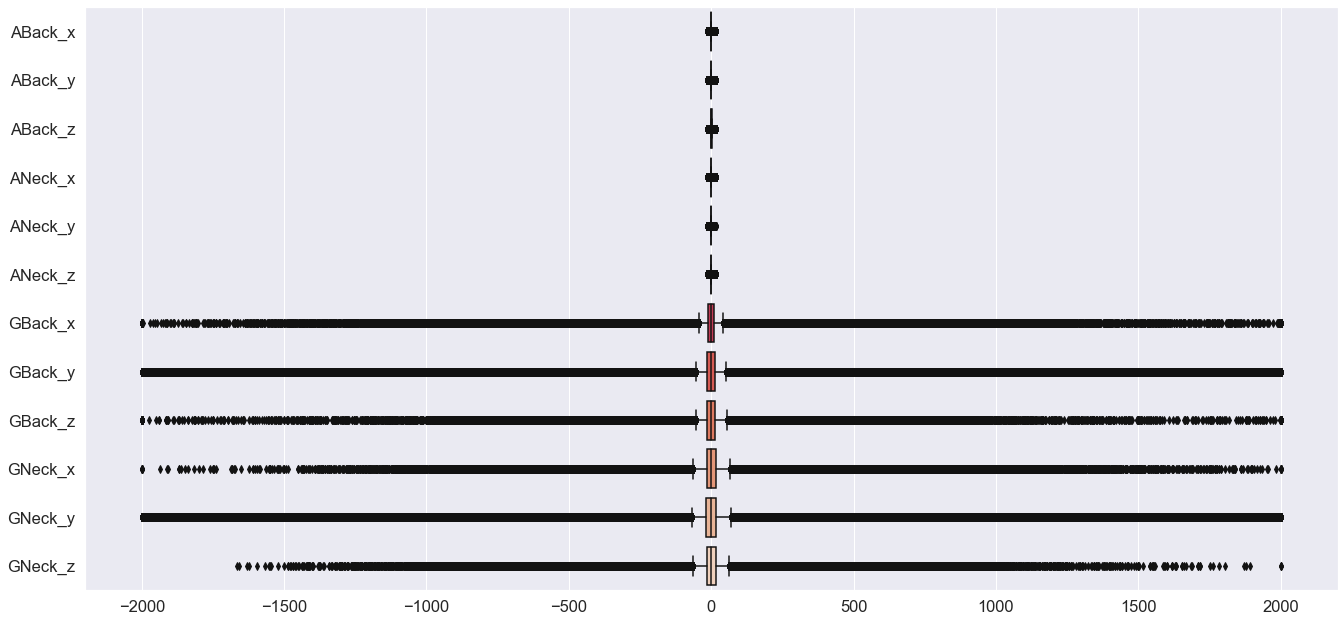

In [55]:
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)

cols = [ 'ABack_x', 'ABack_y', 'ABack_z', 'ANeck_x',
       'ANeck_y', 'ANeck_z', 'GBack_x', 'GBack_y', 'GBack_z', 'GNeck_x',
       'GNeck_y', 'GNeck_z',]
plt.figure(figsize=(20, 10))
sns.boxplot(data=data[cols], orient="h", palette="rocket")